In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [6]:
df = pd.read_csv("TTLCON.csv", parse_dates=True, index_col="DATE")
df.index.freq="MS"

In [7]:
df.describe()

,TTLCON
count,120.000000
mean,88216.833333
std,19533.130602
min,50973.000000
25%,73332.250000
50%,86840.500000
75%,106361.750000
max,122010.000000


Text(0.5, 0, '')

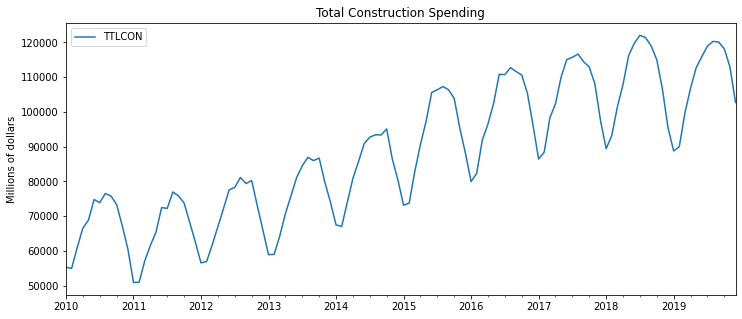

In [8]:
ax = df.plot(figsize=(12,5))
plt.title("Total Construction Spending")
plt.ylabel("Millions of dollars")
plt.xlabel("")

In [9]:
adfuller(df.TTLCON)

(-1.0060633845743006,
 0.7510464016810172,
 13,
 106,
 {'1%': -3.4936021509366793,
  '5%': -2.8892174239808703,
  '10%': -2.58153320754717},
 1852.3576355439993)

In [10]:
adfuller(df.TTLCON.diff(2).dropna())

(-3.2109969822637976,
 0.01935689015691865,
 13,
 104,
 {'1%': -3.4948504603223145,
  '5%': -2.889758398668639,
  '10%': -2.5818220155325444},
 1814.0888303127529)

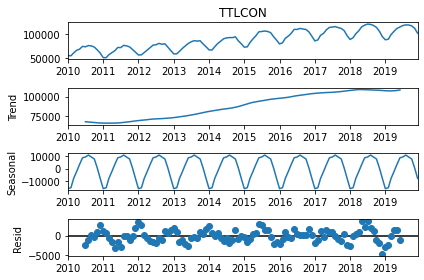

In [11]:
res_season = seasonal_decompose(df.TTLCON)
res_season.plot();

In [12]:
def evaluate_model(model, start, test, model_name, **kwargs):
    """ Function to evaluate predictions against test set.
    
    Args:
        model: model to produce predictions
        start: start index of prediction usually len(train)
        test: test data
        model_name: name to rename the model data
        **kwargs: additional parameters for predict function
        
    Returns:
        predictions
    """
    predictions = model.predict(start=start, end=start+len(test)-1, dynamic=False, **kwargs).rename(model_name)
    print(f"MSE for {model_name}: \t{mean_squared_error(test, predictions)}")
    print(f"RMSE for {model_name}: \t{rmse(test, predictions)}")
    return predictions

In [13]:
def plot_results(test, predictions):
    """ Plots the predicted data and test data to visualise the predictions.
    
    Args:
        test: test data
        prediction: predictions data
    """
    title = "Compare prediction with test set"
    xlabel = "date"
    ylabel="Millions of units"
    
    ax = test.plot(legend=True, figsize=(12,6), title=title, label="Test data")
    predictions.plot(legend=True)
    ax.autoscale(axis="x", tight=True)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [27]:
stepwise = auto_arima(
    df.TTLCON,
    m=12,
    d=None,
    D=None,
    start_p=1,
    start_q=1,
    max_p=4,
    max_d=4,
    max_q=4,
    max_P=4,
    max_D=4,
    max_Q=4,
    stepwise=False,
    trace=True,
    n_jobs=-1
)
stepwise.summary()

Total fit time: 94.499 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1024.804
Date:                            Sun, 14 Jun 2020   AIC                           2061.608
Time:                                    12:58:44   BIC                           2077.701
Sample:                                         0   HQIC                          2068.133
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    788.8333   1427.950      0.552      0.581   -2009.897    3587.564
ar.L1          1.1449      0.337      3.394      0.001       0.484       1.806
ar.L2         -0.2910      0.084     -3.448      0.001      -0.456      -0.126
ma.L1         -0.8167      0.372     -2.194      0.028      -1.546      -0.087
ma.S.L12      -0.0739      0.127     -0.580      0.562      -0.324       0.176
sigma2      1.005e+07      0.795   1.26e+07      0.000       1e+07       1e+07
===================================================================================
Ljung-Box (Q):                      273.52   Jarque-Bera (JB):               186.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                            -1.45
Prob(H) (two-sided):                  0.56   Kurtosis:                         8.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.36e+22. Standard errors may be unstable.
"""

In [14]:
s_index = -12
train = df.iloc[:s_index]
test = df.iloc[s_index:]

In [15]:
sarimax_1 = SARIMAX(train.TTLCON, order=(2,0,1), seasonal_order=(0,1,1,12)).fit()


/home/sqauess/Documents/University/TimeSeries/venv/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [16]:
res_sarimax_1 = evaluate_model(sarimax_1, len(train), test.TTLCON, "")

MSE for : 	11907694.13276179
RMSE for : 	3450.752690756292


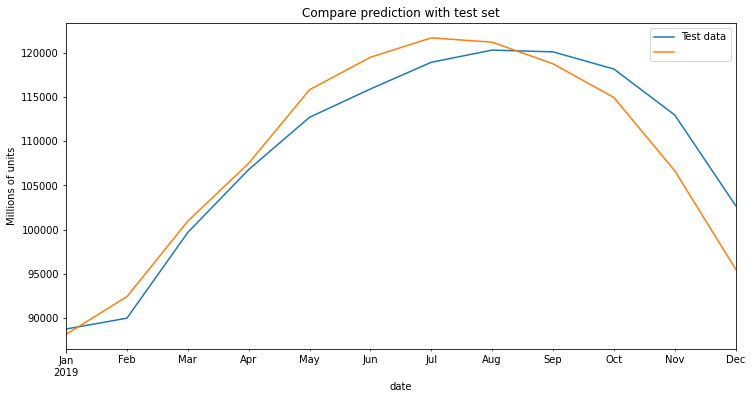

In [17]:
plot_results(test.TTLCON, res_sarimax_1)

In [18]:
sarimax_1_d_1 = SARIMAX(train.TTLCON, order=(2,1,1), seasonal_order=(0,1,1,12)).fit()
res_sarimax_1_d_1 = evaluate_model(sarimax_1_d_1, len(train), test.TTLCON, "")

/home/sqauess/Documents/University/TimeSeries/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/sqauess/Documents/University/TimeSeries/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MSE for : 	16344195.905339887
RMSE for : 	4042.7955557188257


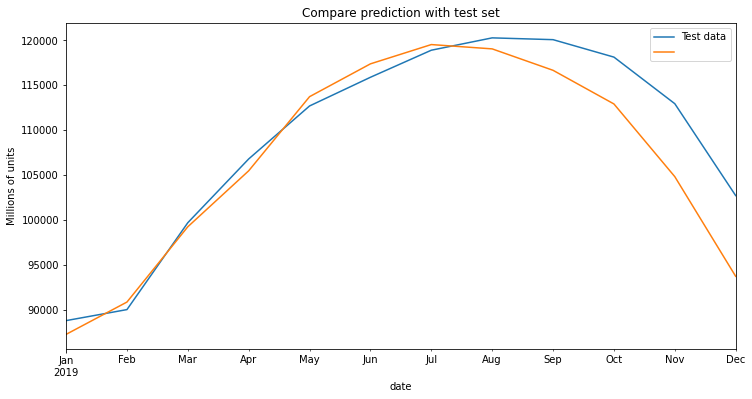

In [19]:
plot_results(test.TTLCON, res_sarimax_1_d_1)

In [20]:
hw_es = ExponentialSmoothing(
    train.TTLCON,
    trend='mul',
    seasonal='mul',
    seasonal_periods=12
).fit()
res_hw_es = hw_es.forecast(12).rename("Exponential Smoothing")
print(f"MSE for Exponential Smoothing: \t{mean_squared_error(test.TTLCON, res_hw_es)}")
print(f"RMSE for Exponential Smoothing: \t{rmse(test.TTLCON, res_hw_es)}")

MSE for Exponential Smoothing: 	18434461.429960623
RMSE for Exponential Smoothing: 	4293.53716997543


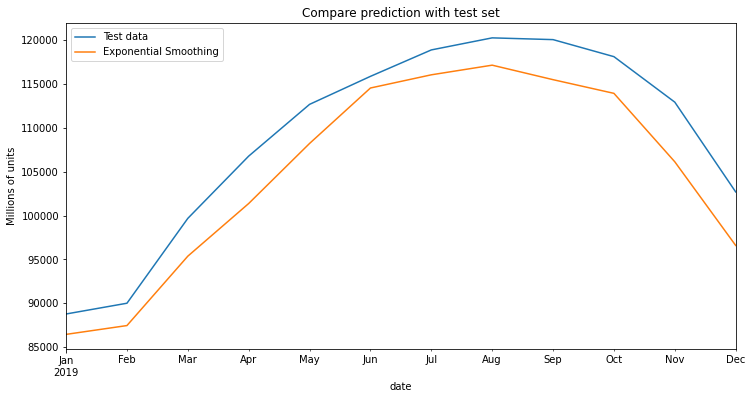

In [21]:
plot_results(test.TTLCON, res_hw_es)

In [22]:
sarimax_1_d_2 = SARIMAX(
    train.TTLCON,
    order=(2,2,1),
    seasonal_order=(0,1,1,12)
).fit()
res_sarimax_1_d_2 = evaluate_model(sarimax_1_d_2, len(train), test.TTLCON, "")

MSE for : 	174749783.12264857
RMSE for : 	13219.295863344938


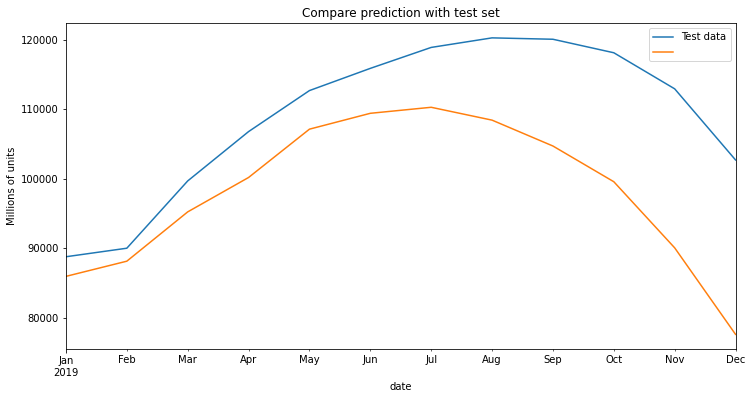

In [23]:
plot_results(test.TTLCON, res_sarimax_1_d_2)

In [24]:
df.head()

,TTLCON
DATE,
2010-01-01,55362
2010-02-01,54986
2010-03-01,60990
2010-04-01,66565
2010-05-01,68903


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


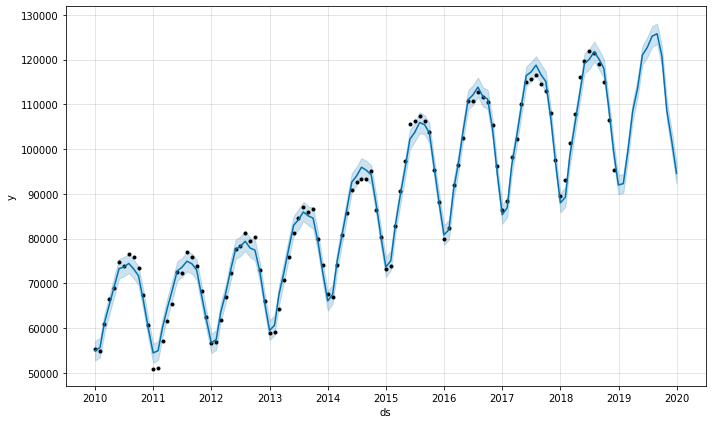

In [40]:
prop_data = pd.read_csv("TTLCON.csv", parse_dates=True)
prop_data.columns = ["ds", "y"]
prop_data.head()
prop_train = prop_data.iloc[:-12]
m = Prophet(seasonality_mode='multiplicative').fit(prop_train)
future = m.make_future_dataframe(periods=13, freq='M')
fcst = m.predict(future)
fig = m.plot(fcst)

In [41]:
fcst[["ds",'yhat']].iloc[-12:]

,ds,yhat
109,2019-01-31,92287.256960
110,2019-02-28,99409.009943
111,2019-03-31,108507.939186
112,2019-04-30,113468.256666
113,2019-05-31,121032.438876
114,2019-06-30,122677.707122
115,2019-07-31,125226.438199
116,2019-08-31,125776.792472
117,2019-09-30,120809.014583
118,2019-10-31,108628.248808


In [46]:
fcst_test = fcst.set_index("ds")


In [47]:
print(f"MSE for Prophet: \t{mean_squared_error(test.TTLCON, fcst_test['yhat'][-12:])}")
print(f"RMSE for Prophet: \t{rmse(test.TTLCON, fcst_test['yhat'][-12:])}")

MSE for Prophet: 	57048913.57835562
RMSE for Prophet: 	7553.073121475498


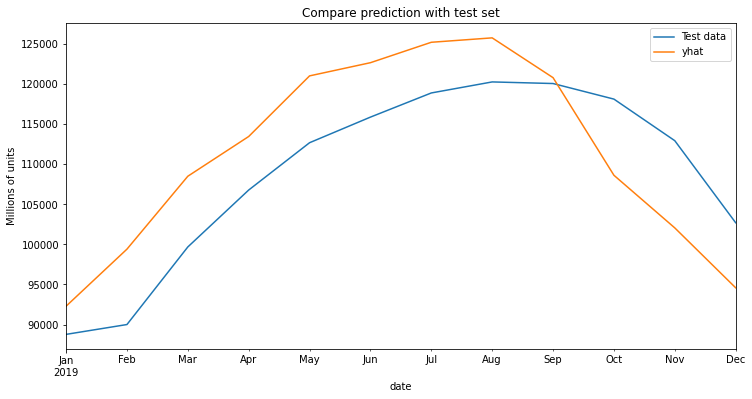

In [48]:
plot_results(test.TTLCON, fcst_test['yhat'][-12:])